# Settings

### Autoreload of ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

### Changing the path to the main directories path

In [2]:
import os
# os.chdir(r"C:\Users\amilion\Documents\GitHub\CNRL-Cortical-Column\src")
os.getcwd()

'c:\\Users\\Asus\\Desktop\\UT\\CNRL - Lab\\CNRL-Cortical-Column\\src'

# Imports

In [3]:
from conex import *
from pymonntorch import *

from matplotlib import pyplot as plt
from PIL import Image

import torchvision
from torch.utils.data import DataLoader

from conex.helpers.filters import DoGFilter

from L423.tools.visualize import *
from L56.RefrenceFrames import RefrenceFrame
from L56.stimuli.current_base import RandomInputCurrent
from L56.synapse.vDistributor import ManualVCoder
from InputLayer.DataLoaderLayer import DataLoaderLayer
from InputLayer.synapse.LocationCoder import LocationCoder
from L423.network.SetTarget import SetTarget
from L423.L423 import L4, L23
from FC import fullyConnected
from FC.synapse.learning import AttentionBasedRSTDP
from FC.tools.model_evaluation import accuracy_score

from L56.tools.visualization import refrence_frame_raster
from L423.tools.visualize import show_filters

from torchvision.datasets import MNIST

# Configs

In [4]:
REFRENCE_FRAME_DIM = 23
REFRENCE_INH_DIM = 15
SCREEN_SHOT_PATH = "C:\\Users\\amilion\\Desktop\\develop\\python\\NS\\records\\L5.6"

Input_Width = 28
Input_Height = 28
Crop_Window_Width = 23
Crop_Window_Height = 23
DoG_SIZE = 5

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_NUMBER = 100

OUT_CHANNEL = 16
IN_CHANNEL = 1
KERNEL_WIDTH = 13
KERNEL_HEIGHT = 13

DATASET_IMAGE_WIDTH = IMAGE_WIDTH - DoG_SIZE + 1
DATASET_IMAGE_HEIGHT = IMAGE_HEIGHT - DoG_SIZE + 1
INPUT_WIDTH = Crop_Window_Width - DoG_SIZE + 1
INPUT_HEIGHT = Crop_Window_Height - DoG_SIZE + 1

L4_WIDTH = Crop_Window_Width - KERNEL_WIDTH + 1
L4_HEIGHT = Crop_Window_Height - KERNEL_HEIGHT + 1

L23_WIDTH = L4_WIDTH//2
L23_HEIGHT = L4_HEIGHT//2

J_0 = 300
p = 0.8

TRAIN_IMAGES_NUMBER = 70
TEST_IMAGES_NUMBER = 40
TRAIN_ITERATIONS = 14000
REST_INTERVAL = 100
TEST_ITERATIONS = 8000

# Loading Data

In [5]:
MNIST_ROOT = "./MNIST"

time_window = 100
crop_iteration = 3

dataset_directory_path = "./first_step"

transformation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels = 1), # not necessary
    Conv2dFilter(DoGFilter(size = 5, sigma_1 = 4, sigma_2 = 1, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)), # type: ignore
    SqueezeTransform(dim = 0), # type: ignore
])


dataset = MNIST(root=MNIST_ROOT, train=True, download=False, transform=transformation)
first_class = dataset.data[dataset.targets == 4][:TRAIN_IMAGES_NUMBER + TEST_IMAGES_NUMBER]
second_class = dataset.data[dataset.targets == 9][:TRAIN_IMAGES_NUMBER + TEST_IMAGES_NUMBER]

target = [0] * len(first_class) + [1] * len(second_class)
target = torch.Tensor(target)

two_class_dataset = torch.cat((first_class, second_class), dim=0)
new_dataset_size = first_class.shape[0] + second_class.shape[0]

t = torch.arange(new_dataset_size)
np.random.shuffle(t.numpy())
two_class_dataset = two_class_dataset[t]
target = target[t]

new_dataset = torch.empty(0, DATASET_IMAGE_WIDTH, DATASET_IMAGE_WIDTH)
centers = []

for i in range(0, new_dataset_size):
    img = two_class_dataset[i]  # 4 in range [0, 5842) ; 9 in range [5842, 11791)
    img = Image.fromarray(img.numpy(), mode="L")
    img = transformation(img)
    # import pdb;pdb.set_trace()
    new_dataset = torch.cat((new_dataset.data, img.data.view(1, *img.data.shape)), dim=0)

dl = DataLoader(new_dataset,shuffle=False)

# Initialize Network

In [6]:
net = Neocortex(
    dt = 1, 
    dtype=torch.float32, 
    behavior = {5 : SetTarget(target = target), 601 : Recorder(["dopamine"]),},
    index=True
)

## L56

In [7]:
L56 = RefrenceFrame(
    net=net, 
    k=5, 
    refrence_frame_side=REFRENCE_FRAME_DIM, 
    inhibitory_size=REFRENCE_INH_DIM,
    competize=True
)

## L4

In [8]:
L4 = L4(
    net = net, 
    IN_CHANNEL = IN_CHANNEL, 
    OUT_CHANNEL = OUT_CHANNEL, 
    HEIGHT = L4_HEIGHT, 
    WIDTH = L4_WIDTH, 
    INH_SIZE = 7
)

# L23

In [9]:
L23 = L23(
    net = net, 
    IN_CHANNEL = IN_CHANNEL, 
    OUT_CHANNEL = OUT_CHANNEL, 
    HEIGHT = L23_HEIGHT, 
    WIDTH = L23_WIDTH
)

## InputLayer

In [10]:
input_layer = DataLoaderLayer(
    net=net,
    data_loader=dl,
    targets=target,
    widnow_size=Crop_Window_Height,
    saccades_on_each_image=3,
    rest_interval=50,
    train_iterations=TRAIN_ITERATIONS,
    phase_interval=REST_INTERVAL,
    test_iterations=TEST_ITERATIONS,
    train_images_number=TRAIN_IMAGES_NUMBER,
    test_images_number=TEST_IMAGES_NUMBER
).build_data_loader()

## FullyConncted

In [11]:
fclayer = fullyConnected.FC(
    net = net, 
    N = 100, 
    K = 2
)

# Synapsis

### Without Learning

In [12]:
Synapsis_L4_L23 = Synapsis(
    net = net,
    src = L4.layer,
    dst = L23.layer,
    input_port="output",
    output_port="input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),
        AveragePool2D(current_coef = 50000),
    ]),
    synaptic_tag="Proximal"
)


Synapsis_Inp_L56 = Synapsis(
    net = net,
    src = input_layer,
    dst = L56.layer,
    input_port = "data_out",
    output_port = "input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),]) | {
        275: LocationCoder()
    },
    synaptic_tag="Proximal"
)

Inp_to_L56 = Synapsis(
    net = net,
    src = input_layer,
    dst = L56.layer,
    input_port = "data_out",
    output_port = "input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),]) | {
        275: LocationCoder()
    },
    synaptic_tag="Proximal"
)

### With Learning

In [13]:
Synapsis_Inp_L4 = Synapsis(
    net = net,
    src = input_layer,
    dst = L4.layer,
    input_port="data_out",
    output_port="input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(weights = torch.normal(0.1, 2, (OUT_CHANNEL, IN_CHANNEL, KERNEL_HEIGHT, KERNEL_WIDTH)) ),
        Conv2dDendriticInput(current_coef = 20000 , stride = 1, padding = 0),
        Conv2dSTDP(a_plus=0.8, a_minus=0.001),
        WeightNormalization(norm = 4)
    ]),
    synaptic_tag="Proximal"
)

Synapsis_L23_FC = Synapsis(
    net = net,
    src = L23.layer,
    dst = fclayer.layer,
    input_port="output",
    output_port="input",
    synapsis_behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(mode = "random"),
        SimpleDendriticInput(current_coef = 100),
        WeightNormalization(norm = 35),
        WeightClip(w_min = 0, w_max = 1.65)
    ]) | ({
        400 : AttentionBasedRSTDP(a_plus = 0.008 , a_minus = 0.001, tau_c = 6, attention_plus = 1, attention_minus = 0),
    }),
    synaptic_tag="Proximal"
)

L23_to_L56 = Synapsis(
    net=net,
    src=L23.layer,
    dst=L56.layer,
    input_port="output",
    output_port="input",
    synaptic_tag="Apical, exi",
    synapsis_behavior=prioritize_behaviors(
        [
            SynapseInit(), 
            SimpleDendriticInput(),
            WeightInitializer(mode="normal(0.05, 0.01)"),
            SimpleSTDP(w_min=0, w_max=100, a_plus=1, a_minus=0.0008)
        ]
    )
)

L56_to_L23 = Synapsis(
    net=net,
    src=L56.layer,
    dst=L23.layer,
    input_port="output",
    output_port="input",
    synaptic_tag="Apical, exi",
    synapsis_behavior=prioritize_behaviors(
        [
            SynapseInit(), 
            SimpleDendriticInput(),
            WeightInitializer(mode="normal(0.05, 0.01)"),
            SimpleSTDP(w_min=0, w_max=10, a_plus=1, a_minus=0.0008)
        ]
    )
)

# Simulate Network

In [14]:
net.initialize()
net.simulate_iterations(TRAIN_ITERATIONS)

Network['Neocortex'](Neurons: tensor(6309)|13 groups, Synapses: tensor(14240534)|49 groups){1:TimeResolution(dt=1,)5:SetTarget(target=tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.

734370.9313869476

# Visualization

## Filters

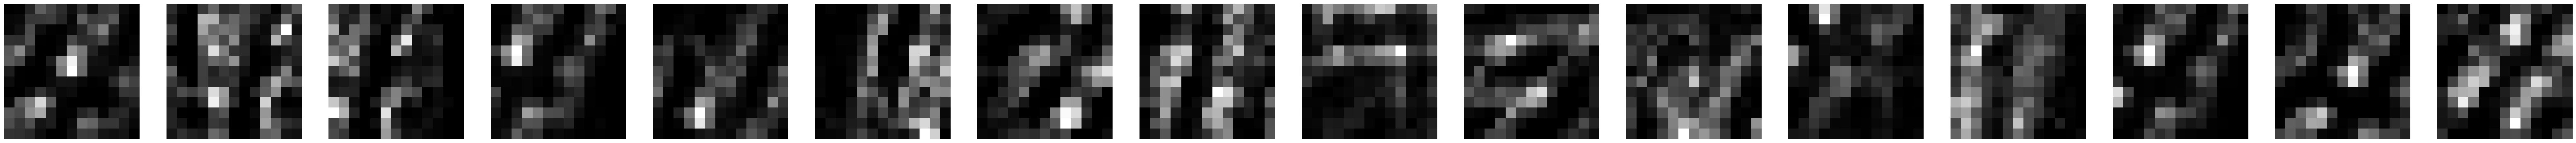

In [15]:
show_filters(Synapsis_Inp_L4.synapses[0].weights)

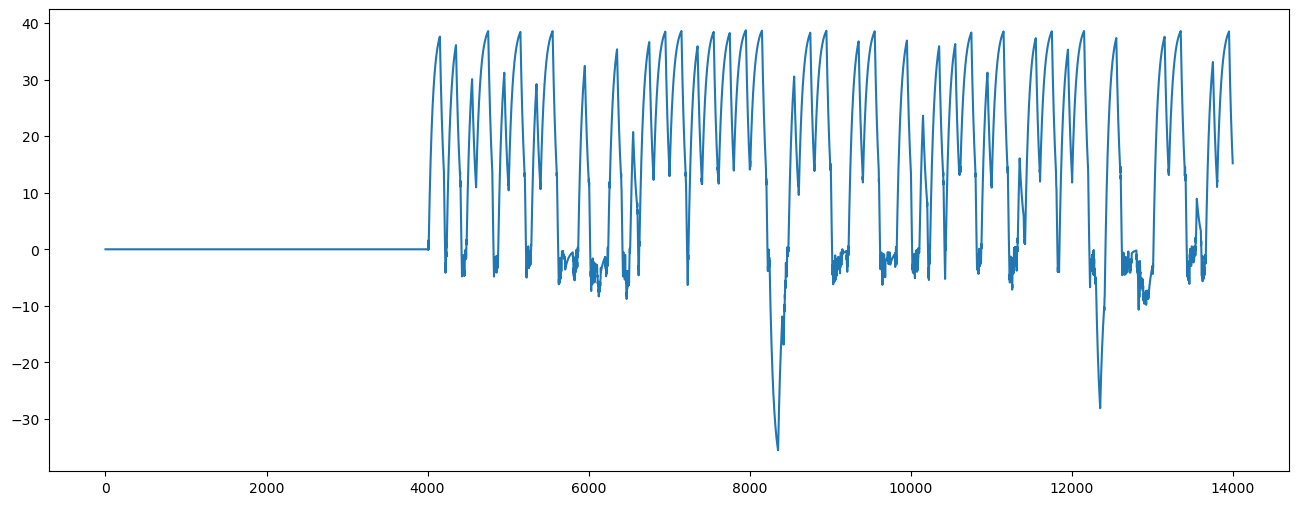

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(net["dopamine", 0])
plt.show()

# Rest Interval

In [17]:
net.simulate_iterations(REST_INTERVAL)

100xBatch: 1/1 (100%) 5314.414ms


5314.414024353027

# Test Section

### Clearing learnings

In [18]:
Synapsis_Inp_L4.remove_behavior(400)
Synapsis_L23_FC.remove_behavior(400)
# L23_to_L56.remove_behavior(400)
# L56_to_L23.remove_behavior(400)

### Disconnect L56_L23

In [19]:
print(L23_to_L56)
print(L56_to_L23)

Synapsis['Synapsis_63', 'Synapsis'](Synapses:['Apical', 'Apical', 'Apical', 'Apical', 'Apical']){}
Synapsis['Synapsis_69', 'Synapsis'](Synapses:['Apical', 'Apical', 'Apical', 'Apical', 'Apical']){}


### Running Network

In [20]:
net.simulate_iterations(TEST_ITERATIONS)
net["targets"]

8000xBatch: 1/1 (100%) 439615.178ms


[tensor([1., 1., 1.,  ..., 0., 0., 0.])]

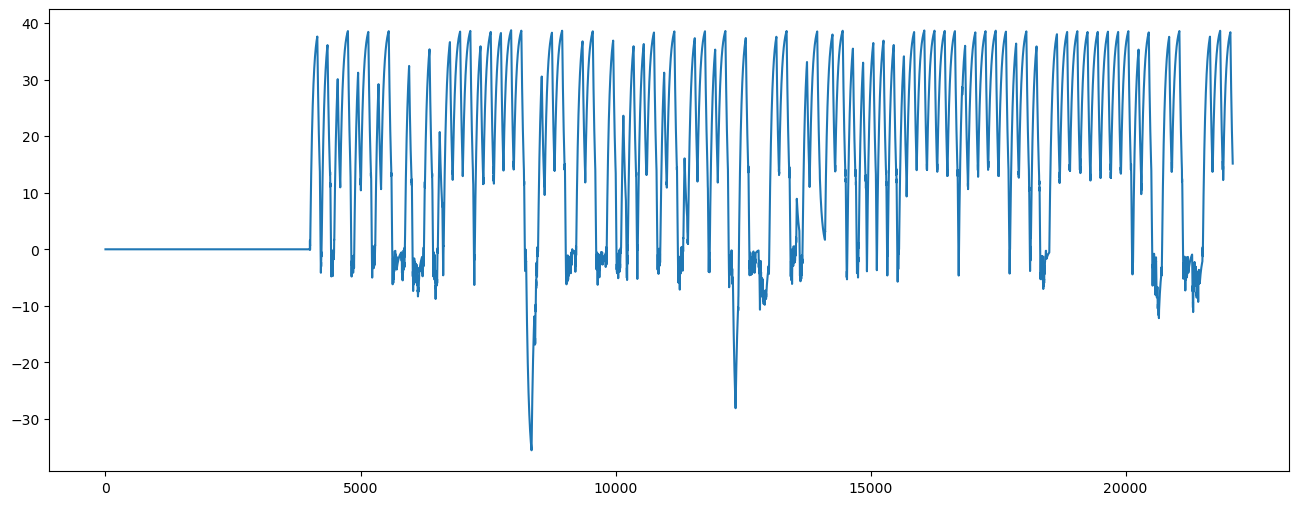

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(net["dopamine", 0])
plt.show()

## Accuracy Score

In [22]:
print("Test Accuracy :", accuracy_score(
    fclayer.E_NG_GROUP, 
    K = 2, 
    window_size = TEST_ITERATIONS // TEST_IMAGES_NUMBER, 
    targets=net["targets"][0], 
    dataset_size = TEST_IMAGES_NUMBER, 
    offset=TRAIN_ITERATIONS + REST_INTERVAL) * 100
)

Test Accuracy : tensor(90.)


# Decision-Making Raster Plot

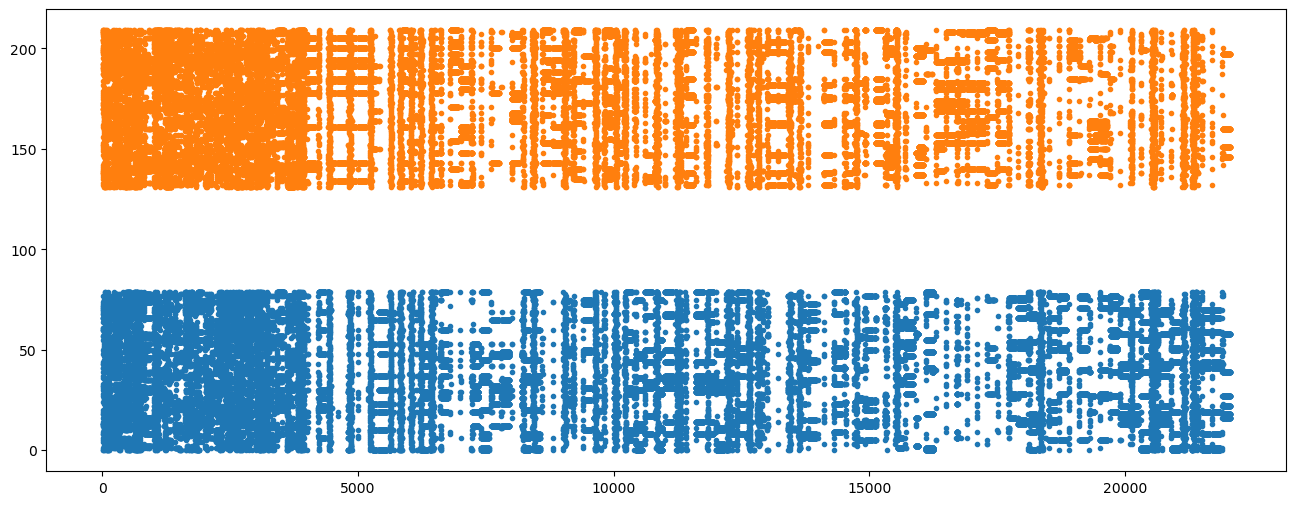

In [23]:
plt.figure(figsize=(16, 6))
# for i in range(fclayer.K) : 
    # a = (i * 1600)
    # b = ((i + 1) * 1600)
    
plt.plot(fclayer.E_NG_GROUP['spikes.t', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] < 80], fclayer.E_NG_GROUP['spikes.i', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] < 80], '.')
plt.plot(fclayer.E_NG_GROUP['spikes.t', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] > 80], fclayer.E_NG_GROUP['spikes.i', 0][fclayer.E_NG_GROUP['spikes', 0][:,1] > 80] + 50, '.')